# The GoogleFit data

This notebook is about GoogleFit data, its features robustness and correlations. We want here to inform the reader about what kind of information the googletimeline_fitbit.pkl file contains and validate it by looking for correlations and visualizing plots.

In [1]:
#import the packages
import sys, re, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from pathlib import Path

%matplotlib notebook

In [2]:
path_cwd = Path(os.getcwd())
path_myaiguide = str(path_cwd.parents[0])
path_file = 'data/preprocessed/googletimeline_fitbit.pkl'
file_pkl = os.path.join(path_myaiguide,path_file)

df = pd.read_pickle(file_pkl)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9351 entries, 0 to 9350
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   startTimestamp              9351 non-null   datetime64[ns, UTC]
 1   endTimestamp                9351 non-null   datetime64[ns, UTC]
 2   InferredTravelMode          7919 non-null   object             
 3   SimplifiedDistanceMeters    621 non-null    float64            
 4   ActivityDistance            4685 non-null   float64            
 5   VisitActivityType           4736 non-null   object             
 6   activitySegment.confidence  4719 non-null   object             
 7   WaypointDistance            3918 non-null   float64            
 8   WayPointConfidence          3261 non-null   float64            
 9   steps_n                     8992 non-null   float64            
 10  taplog_activity             1139 non-null   object          

## Meaning of the columns

The following columns originate from the GoogleFit Semantic Location History files (hereafter I will call these files as SemLocHist):

In [4]:
df.columns

Index(['startTimestamp', 'endTimestamp', 'InferredTravelMode',
       'SimplifiedDistanceMeters', 'ActivityDistance', 'VisitActivityType',
       'activitySegment.confidence', 'WaypointDistance', 'WayPointConfidence',
       'steps_n', 'taplog_activity', 'time_activity_fraction', 'calories',
       'meanHeartRate'],
      dtype='object')

+ For 'startTimestamp', and 'endTimestamp' the meaning is clear. We assumed that the time is referred to UTC.
+ At this stage, it is not fully clear the difference between the columns 'InferredTravelMode' and 'VisitActivityType', because both represent an activity. 'VisitActivityType' seems an inferred activity  and reports the probability of many different possible activities. Here I selected the one with highest probability. 'InferredTravelMode' and 'VisitActivityType' don't match all the time.
+ about 'InferredTravelMode': in SemLocHist files are reported activity types (such as 'WALK', for instance) and, in a separated key called 'placeVisit', the 'placeVisitType' key reports 'SINGLE PLACE'. We assumed this means that the user moved around a particular location, such as a hotel, a park, or a shopping center. Because the two information never overlap in time I put them in the same column.
+ the difference between the distances 'SimplifiedDistanceMeters', 'ActivityDistance', and  'WaypointDistance' is unclear.
+ we assume that 'activitySegment.confidence' is the confidence of the inferred 'VisitActivityType'.
+ similarly, 'WayPointConfidence' seems to be a kind of confidence about the 'WaypointDistance' (or maybe about the full waypoints sequence reported in SemLocHist files).
+ 'steps_n' is the number of steps in that particular time interval. They are derived from the cross-match between the logqs/Physical\ Activity/steps-* files and the SemLocHist files.
+ 'taplog_activity' is the sport activity reported in the file "sport.csv' cross-matched with the time reported in the 'TapLog2020_08_09until2022_07_30.csv' file and the time in SemLocHist.
+ 'time_activity_fraction' represents how much of the taplog time interval overlaps the SemLocHist time intervals. A value of 1 means that the Taplog interval is fully included or it fully includes the SemLocHist interval. In othere words, it is defined as time_activity_fraction = (taplog time interval lenght overlapping the SemLocHist interval) / (endTimestamp - startTimestamp).
+ 'calories' are derived from the match between the logqs/Physical\ Activity/calories-* files and the SemLocHist files.
+ 'meanHeartRate' represents the mean heart beat rate derived from the match between the logqs/Physical\ Activity/heart-rate-* files and the SemLocHist files.

## Which distance?
We here compare different kind of distances to see if they match or there is one more meaningful than others. 'ActivityDistance' is the most numerous together with 'WaypointDistance', while 'SimplifiedDistanceMeters' has few data points. We compare them to ActivityDistance.

In [5]:
df['SimplifiedDistanceDiff'] = (df.SimplifiedDistanceMeters-df.ActivityDistance) / df.ActivityDistance
df['WaypointDistanceDiff'] = (df.WaypointDistance-df.ActivityDistance) / df.ActivityDistance
df['TimeInterval'] = (df.endTimestamp - df.startTimestamp).dt.total_seconds()
df['Speed'] = df.ActivityDistance / df.TimeInterval
df['Speed_wpd'] = df.WaypointDistance / df.TimeInterval
df['Speed_sd'] = df.SimplifiedDistanceMeters / df.TimeInterval

<IPython.core.display.Javascript object>


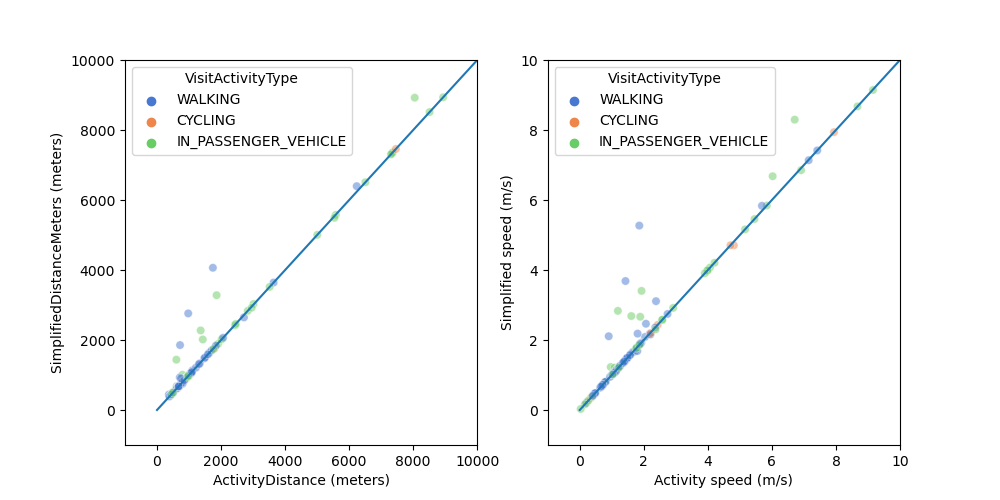

Text(0.5, 0, 'Activity speed (m/s)')

In [6]:
#boole_walk = (df.InferredTravelMode == 'BICYCLE') | (df.InferredTravelMode == 'WALK') |  (df.InferredTravelMode == 'DRIVE')
boole_activity = (df.VisitActivityType == 'CYCLING') | (df.VisitActivityType == 'WALKING') |  (df.VisitActivityType == 'IN_PASSENGER_VEHICLE')
boole_taplog = (df.taplog_activity == 'Walk') | (df.taplog_activity == 'Cycling') | (df.taplog_activity == 'Climbing')

fig, axes = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)#, sharex=True, sharey=True)

sns.scatterplot(x='ActivityDistance', y='SimplifiedDistanceMeters', hue='VisitActivityType',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=df[boole_activity], ax=axes[0])

axes[0].plot([0,100000],[0,100000])
axes[0].set_xlim(-1000,10000)
axes[0].set_ylim(-1000,10000)
axes[0].set_xlabel('ActivityDistance (meters)')
axes[0].set_ylabel('SimplifiedDistanceMeters (meters)')

sns.scatterplot(x='Speed', y='Speed_sd', hue='VisitActivityType',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=df[boole_activity], ax=axes[1])

axes[1].plot([0,20],[0,20])
axes[1].set_xlim(-1,10)
axes[1].set_ylim(-1,10)
axes[1].set_ylabel('Simplified speed (m/s)')
axes[1].set_xlabel('Activity speed (m/s)')

In the figure above we compare the two distances and the speeds (expressed in m/s) computed in the same time interval for three different activity types. The solid line represent the one-to-one corrispondence.
SimplifiedDistance and the related speed match quite well with Activity distance and speed. However, very few points have this value. We will not consider it. We look now at the WaypointDistance.

<IPython.core.display.Javascript object>


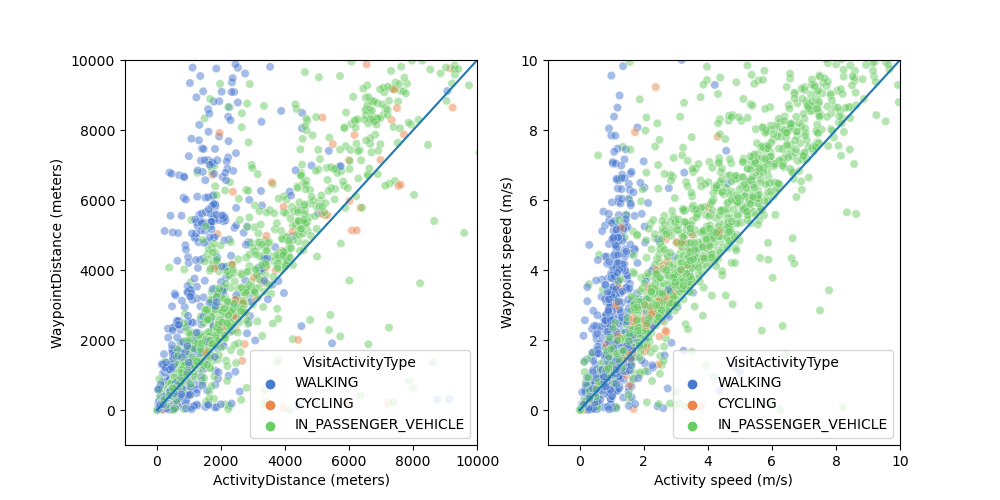

Text(0.5, 0, 'Activity speed (m/s)')

In [7]:
#boole_walk = (df.InferredTravelMode == 'BICYCLE') | (df.InferredTravelMode == 'WALK') |  (df.InferredTravelMode == 'DRIVE')
boole_activity = (df.VisitActivityType == 'CYCLING') | (df.VisitActivityType == 'WALKING') |  (df.VisitActivityType == 'IN_PASSENGER_VEHICLE')
boole_taplog = (df.taplog_activity == 'Walk') | (df.taplog_activity == 'Cycling') | (df.taplog_activity == 'Climbing')

fig, axes = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)#, sharex=True, sharey=True)

sns.scatterplot(x='ActivityDistance', y='WaypointDistance', hue='VisitActivityType',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=df[boole_activity], ax=axes[0])

axes[0].plot([0,100000],[0,100000])
axes[0].set_xlim(-1000,10000)
axes[0].set_ylim(-1000,10000)
axes[0].set_xlabel('ActivityDistance (meters)')
axes[0].set_ylabel('WaypointDistance (meters)')

sns.scatterplot(x='Speed', y='Speed_wpd', hue='VisitActivityType',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=df[boole_activity], ax=axes[1])

axes[1].plot([0,20],[0,20])
axes[1].set_xlim(-1,10)
axes[1].set_ylim(-1,10)
axes[1].set_ylabel('Waypoint speed (m/s)')
axes[1].set_xlabel('Activity speed (m/s)')

While for 'CYCLING' and 'IN_PASSENGER_VEHICLE' the corrispondence seems fair (although WaypointDistance is in average larger than ActivityDistance), for 'WALKING' the distances and the related speeds do not match well. We must notice that a realistic walking speed should be in general lower than 2 m/s while the speeds obtained by using the waypoint distance appear to be much higher for a large fraction of points.

**Thus we conclude that 'ActivityDistance' is a more realistic and robust measure than WaypointDistance.**

## The taplog information
The taplogs considered here cover the time between 2020-08-09 and 2022-07-30. Since the taplog information is more trusted, we use it as reference to check the GoogleFit data.

In [8]:
boole_taplog = df.taplog_activity.notna()

In [9]:
df[boole_taplog].head(10)

,startTimestamp,endTimestamp,InferredTravelMode,SimplifiedDistanceMeters,ActivityDistance,VisitActivityType,activitySegment.confidence,WaypointDistance,WayPointConfidence,steps_n,taplog_activity,time_activity_fraction,calories,meanHeartRate,SimplifiedDistanceDiff,WaypointDistanceDiff,TimeInterval,Speed,Speed_wpd,Speed_sd
4903,2020-08-09 16:57:08.822000+00:00,2020-08-09 17:16:32.488000+00:00,WALK,NaN,2207.0,CYCLING,MEDIUM,2250.681193,0.993350,1313.916667,Walk,0.683238,124.444500,118.046392,NaN,0.019792,1163.666,1.896592,1.934130,NaN
4904,2020-08-09 17:16:32.488000+00:00,2020-08-09 18:15:34.118000+00:00,SINGLE_PLACE,1373.759094,NaN,NaN,NaN,NaN,NaN,2240.533333,Walk,0.933552,292.773667,107.000000,NaN,NaN,3541.630,NaN,NaN,0.387889
4912,2020-08-10 16:06:32.170000+00:00,2020-08-10 17:11:38.432000+00:00,WALK,NaN,7709.0,CYCLING,MEDIUM,7871.107369,0.973310,2934.700000,Walk,0.214773,313.023333,103.813445,NaN,0.021028,3906.262,1.973498,2.014997,NaN
4913,2020-08-10 17:11:38.432000+00:00,2020-08-10 18:39:24.362000+00:00,SINGLE_PLACE,2069.705959,NaN,NaN,NaN,NaN,NaN,2933.900000,Walk,1.000000,293.389333,86.459103,NaN,NaN,5265.930,NaN,NaN,0.393037
4914,2020-08-10 18:39:24.362000+00:00,2020-08-10 18:45:14.759000+00:00,WALK,NaN,274.0,WALKING,LOW,357.479641,0.966698,353.150000,Walk,0.205130,30.607500,95.529412,NaN,0.304670,350.397,0.781970,1.020213,NaN
4924,2020-08-11 16:37:01.329000+00:00,2020-08-11 17:08:27+00:00,WALK,NaN,2737.0,CYCLING,LOW,1883.690978,1.000000,1606.800000,Walk,0.455049,167.643333,112.983713,NaN,-0.311768,1885.671,1.451473,0.998950,NaN
4925,2020-08-11 17:08:27+00:00,2020-08-11 17:17:59.040000+00:00,SINGLE_PLACE,179.263715,NaN,NaN,NaN,NaN,NaN,190.666667,Walk,1.000000,25.521500,80.895833,NaN,NaN,572.040,NaN,NaN,0.313376
4926,2020-08-11 17:17:59.040000+00:00,2020-08-11 17:24:12.354000+00:00,NaN,1756.866087,1796.0,CYCLING,LOW,NaN,NaN,86.133333,Walk,0.020404,12.340000,77.574074,-0.021789,NaN,373.314,4.810963,NaN,4.706135
4936,2020-08-12 17:20:41.539000+00:00,2020-08-12 17:49:04.379000+00:00,WALK,NaN,2769.0,CYCLING,LOW,2795.223394,0.991153,1316.533333,Walk,0.386863,176.157667,126.206897,NaN,0.009470,1702.840,1.626107,1.641507,NaN
4937,2020-08-12 17:49:04.379000+00:00,2020-08-12 18:27:01.127000+00:00,SINGLE_PLACE,1244.035254,NaN,NaN,NaN,NaN,NaN,1412.266667,Walk,1.000000,228.880167,129.652318,NaN,NaN,2276.748,NaN,NaN,0.546409


In the following we manipulate the variable names to make the data more handy.

In [10]:
#replace nan activity with 'NONE'
df.taplog_activity = df.taplog_activity.fillna('NONE')
#in the following case, np.nan correspond to 'SINGLE_PLACE' of the InferredTravelMode.
# we use it here as activity to distinguish it from the other activities.
df.VisitActivityType = df.VisitActivityType.fillna('SINGLE_PLACE')

As distance we want to use ActivityDistance but this has some nan values. Let's see if there are other distances we can use when ActivityDistance is missing.

In [11]:
boole = (df.ActivityDistance.isna()) & (df.SimplifiedDistanceMeters.notna())
print('number of matching distances for SimplifiedDistance is ', boole.sum())

number of matching distances for SimplifiedDistance is  350


In [12]:
#as distance we use ActivityDistance and SimplifiedDistanceMeters.
#when the first is missing, we replace it with the second one.
boole = (df.ActivityDistance.isna()) & (df.WaypointDistance.notna())

print('number of matching distances for WaypointDistance is ', boole.sum())
#we use WaypointDistance when no ActivityDistance is available
df.loc[boole,'ActivityDistance'] = df.WaypointDistance[boole]

number of matching distances for WaypointDistance is  16


We use ActivityDistance, while WaypointDistance is used only when the first one is not available.

In [13]:
#define some new variables that may be useful later
df['StepLength'] = df.ActivityDistance / df.steps_n
#df['StepsPerMeter'] = df.steps / df.ActivityDistance
df['StepsPerSec'] = df.steps_n / df.TimeInterval
df['cal/min'] = 60 * df.calories / df.TimeInterval

Now, we want to check if the 'VisitActivtyType' match the activity reported by the trustworthy 'taplog_activity' variable. To do so, we cross-match the number of counts of the activities by using the confusion_matrix and selecting the taplog_activity that match 'VisitActivtyType' with a time fraction larger than 0.9, so that we are sure that at least 90% of the time interval reported by Taplog overlap the one recorded in SemLocHist.

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

boole_taplog = (df.taplog_activity.notna()) & (df.time_activity_fraction > 0.9)
#set dataframe that contain the selected rows
df_tap = df[boole_taplog].copy()
#encode the activities
le= LabelEncoder()
le.fit(df_tap.VisitActivityType.tolist() + df_tap.taplog_activity.tolist())
df_tap['VisitAct_label'] = le.transform(df_tap.VisitActivityType.tolist())
df_tap['taplog_label'] = le.transform(df_tap.taplog_activity.tolist())



<IPython.core.display.Javascript object>


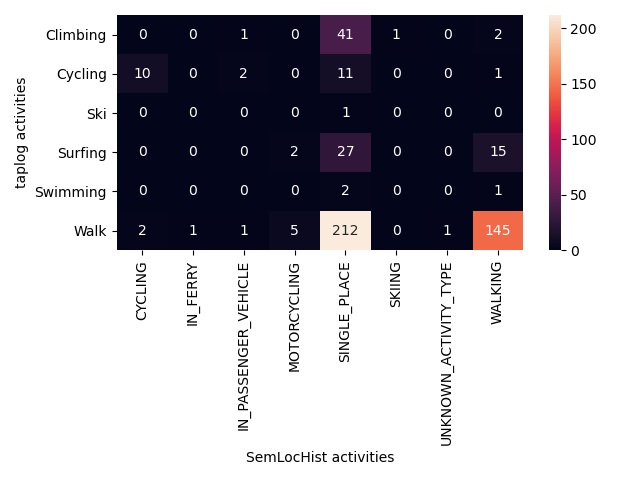

In [15]:
#compute the confusion matrix
conf_mat = confusion_matrix(df_tap.taplog_label, df_tap.VisitAct_label)
#put it in a dataframe
df_matrix = pd.DataFrame(conf_mat, index=le.classes_, columns=le.classes_)
#now, we drop some zeros columns to compare the activities in taplog with the ones in SemLocHist
df_matrix.drop(columns=df_matrix.columns[df_matrix.sum(axis=0)==0], inplace=True)
df_matrix.drop(index=df_matrix.index[df_matrix.sum(axis=1)==0], inplace=True)
#plot it
fig, ax = plt.subplots()
g = sns.heatmap(df_matrix, annot=True, fmt='d')
ax.set_xlabel('SemLocHist activities')
ax.set_ylabel('taplog activities')
plt.tight_layout()
plt.show()

From the 2D histogram above, we see that a large fraction of activities that were recorded as 'Walk' in Taplog correspond to 'WALKING' and 'VISIT_PLACE' in SemLocHist. 'VISIT_PLACE' seems to be the activity that Google identified as moving around a place such as a hotel, a park or similar. By assuming that one always walk in a 'VISIT_PLACE' then the 'WALKING' precision is high. However one can also bike in a park and, in fact, we see that the Taplog activity 'Cycling' correspond 11 times to a 'VISIT_PLACE' and 10 times to 'CYCLING'. Thus, there is some uncertain.

The precision seem a bit mixed, with a fair precision for the Taplog 'Walk' activity and lower for other activities. Besides, we do not have Taplog records for activities such as 'Motorcycling', 'Driving' and similar, so we cannot check how they have been classified by Google. 

However, we can try a cross-check between the activity and the average length of the steps counted computed as number of steps over distance. For "in vehicle" activities, the length should be high because the greater speed and lower number of steps.

<IPython.core.display.Javascript object>


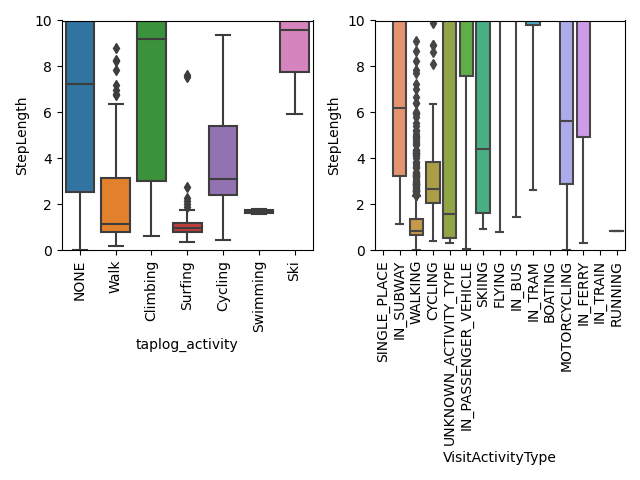

In [16]:
fig, ax = plt.subplots(ncols=2, nrows=1)
sns.boxplot(y="StepLength",
            x='taplog_activity',
            data=df, ax=ax[0])
sns.boxplot(y="StepLength",
            x="VisitActivityType",
            data=df, ax=ax[1])
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_ylim(0,10)
ax[1].set_ylim(0,10)
ax[1].tick_params(axis='x', rotation=90)

fig.tight_layout()
plt.show()

From the plot above we see, in fact, that the average step length (in meters) is around 1 for activities such as "WALK" or "SINGLE_PLACE" (despite some outliers) and much larger for "in vehicle" activities. This supports the correctness of the SemLocHist activities classification (in average).



<IPython.core.display.Javascript object>


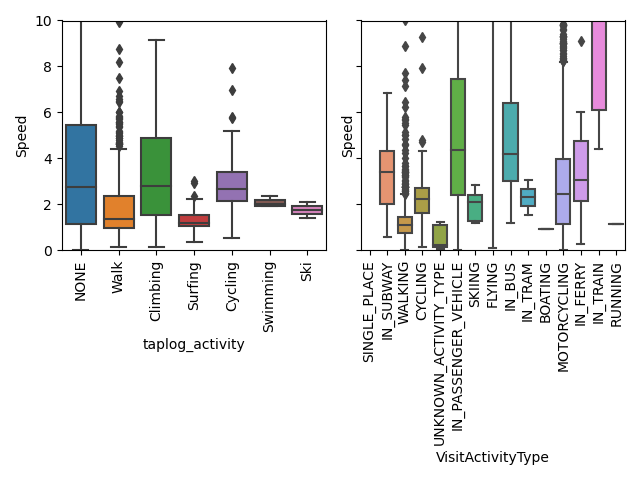

In [17]:
fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True)
sns.boxplot(y="Speed",
            x='taplog_activity',
            data=df, ax=ax[0])
sns.boxplot(y='Speed',
            x="VisitActivityType",
            data=df, ax=ax[1])
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_ylim(0.,10)
ax[1].tick_params(axis='x', rotation=90)

fig.tight_layout()
plt.show()

Also the speeds seem to support the activities reported, with 'walk' having a lower speed than 'cycling', 'in passenger vehicle', and 'in train' activity. 

Therefore, as a first approximation, I would suggest to trust the reported SemLocHist Activities and use them to perform the computation we want, such as removing the steps counted when the user is actually driving/Motorbyking/travelling with a vehicle. 

## Is there correlation between steps/sec, heart rate, and cal/min?
A higher step frequency should indicate a higher physical activity which should push to higher heart rate and calories spent per minute. As a quality check we want to verify if these variables correlate as expected. In the following we plot the distribution of cal/min, mean Heart Rate and steps/sec for taplog activity and VisitActivityType and compare the two.

<IPython.core.display.Javascript object>


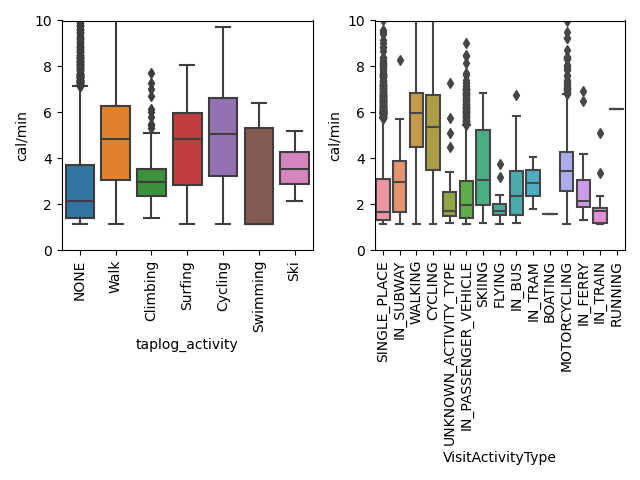

In [18]:
fig, ax = plt.subplots(ncols=2, nrows=1)
sns.boxplot(y="cal/min",
            x='taplog_activity',
            data=df, ax=ax[0])
sns.boxplot(y="cal/min",
            x="VisitActivityType",
            data=df, ax=ax[1])
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_ylim(0,10)
ax[1].set_ylim(0,10)
ax[1].tick_params(axis='x', rotation=90)

fig.tight_layout()
plt.show()

For taplog activity, walk and cycling show a higher calories consumption. However we would expect that climbing should be higher than walking, but this does not seem to be the case. For VisitActivityType the cal/min seem reasonable, with physical atctivities such as walking, cycling, and skiing having higher values than other "in vehicle" activities.

<IPython.core.display.Javascript object>


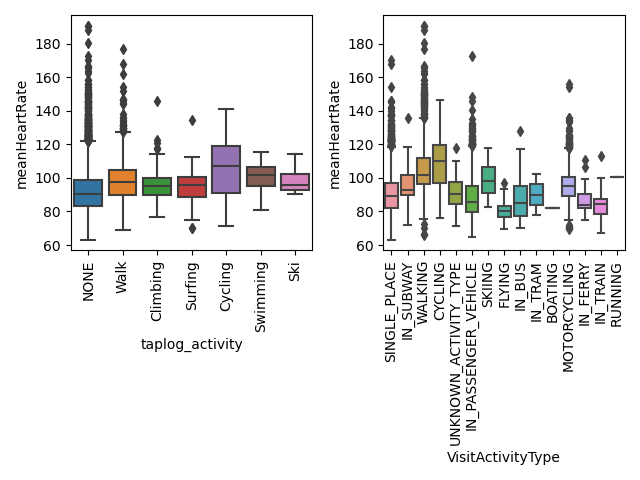

In [19]:
fig, ax = plt.subplots(ncols=2, nrows=1)
sns.boxplot(y="meanHeartRate",
            x='taplog_activity',
            data=df, ax=ax[0])
sns.boxplot(y="meanHeartRate",
            x="VisitActivityType",
            data=df, ax=ax[1])
ax[0].tick_params(axis='x', rotation=90)
#ax[1].set_ylim(0.015,0.05)
ax[1].tick_params(axis='x', rotation=90)

fig.tight_layout()
plt.show()

For mean heart rate we see that the physical activities have in average higher values than the activities that represent travelling. However, the difference is not so clear. In fact some  travelling distributions overlap the physical activity ones. 

<IPython.core.display.Javascript object>


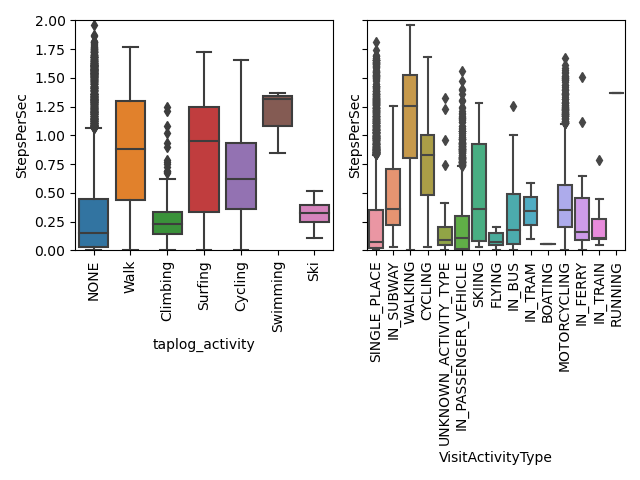

In [20]:
fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True)
sns.boxplot(y="StepsPerSec",
            x='taplog_activity',
            data=df, ax=ax[0])
sns.boxplot(y='StepsPerSec',
            x="VisitActivityType",
            data=df, ax=ax[1])
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_ylim(0.,2)
ax[1].tick_params(axis='x', rotation=90)

fig.tight_layout()
plt.show()

Like before, the number of steps per seconds is in general higher for physical activities such as walking or cycling.

### Correlation matrixes
If during the travelling activity the counted steps were fake (mistaken) steps, then by removing such steps should increase the correlation between the variables 'meanHeartRate', 'cal/min',and 'StepsPerSec'.

In [21]:
vehicle_activity = ['IN_SUBWAY', 'IN_PASSENGER_VEHICLE', 'UNKNOWN_ACTIVITY_TYPE',
                   'FLYING', 'IN_BUS', 'IN_TRAM', 'BOATING', 'MOTORCYCLING',
                   'IN_FERRY', 'IN_TRAIN']
#set a columns with boolean True when not in vehicle
df['vehicle_excluded'] = df.apply(lambda row: False if row.VisitActivityType in vehicle_activity else True, axis=1)


Let's compute the correlation matrix between these variables with no correction for the "vehicle"activities" 

In [22]:
df[['meanHeartRate', 'cal/min','StepsPerSec']].corr()

,meanHeartRate,cal/min,StepsPerSec
meanHeartRate,1.000000,0.735628,0.618062
cal/min,0.735628,1.000000,0.907027
StepsPerSec,0.618062,0.907027,1.000000


now we remove the "vehicle activities" from the correlation matrix computation

In [23]:
boole_corr = df['vehicle_excluded'].values
df.loc[boole_corr,['meanHeartRate', 'cal/min','StepsPerSec']].corr()

,meanHeartRate,cal/min,StepsPerSec
meanHeartRate,1.000000,0.742913,0.638151
cal/min,0.742913,1.000000,0.926519
StepsPerSec,0.638151,0.926519,1.000000


We see that after the correction for the "vehicle activities" the correlation values become higher. This lead us to think that the steps counted during "vehicle activities" may in fact be fake steps. On the other hand, the difference in correlation is small.

### Eyeballing the timeline
We provide here a tool to check by eye the correlation between the VisitActivityType and values such as 'meanHeartRate', 'cal/min', 'StepsPerSec'. We expect these values being greater when a sport activity is reported.

In [24]:
def make_boole_day(df, col, day_start,day_end):
    return (df[col]>day_start) & (df[col]<day_end)

#put here the beginning and ending day of the time interval you want to visualize
day_start = pd.Timestamp('2021-2-7', tz='utc')
day_end = pd.Timestamp('2021-2-8', tz='utc')

boole_day = make_boole_day(df, 'startTimestamp', day_start,day_end)

from matplotlib.cm import rainbow

list_cat = df.VisitActivityType.unique().tolist()
num_cat = len(list_cat)

col_map = dict(zip(list_cat,[rainbow(float(i)/num_cat) for i in np.arange(num_cat)]))


<IPython.core.display.Javascript object>


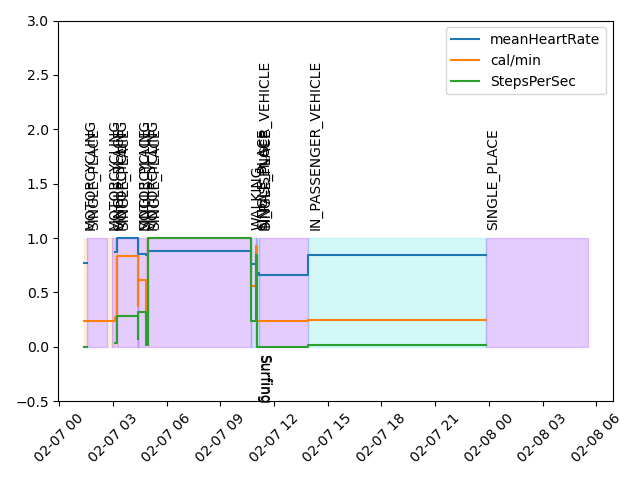

In [30]:
fig = plt.figure()
#fig.plot(t, s1, t, s2)

for idx,row in df[boole_day].iterrows():
    if row.taplog_activity != 'NONE':
        x = [row.startTimestamp, row.endTimestamp]
        #print(row.taplog_activity)
        text = plt.annotate(row.taplog_activity, xy=(x[1], -0.5))
        text.set_rotation(-90)

act_prev = None
col_now = 'green'
for idx,row in df[boole_day].iterrows():
    x = [row.startTimestamp, row.endTimestamp]
    plt.fill_between(x, [0.,0.], [1,1], alpha=0.2, color=col_map[row.VisitActivityType])
    text = plt.annotate(row.VisitActivityType, xy=(x[0], 1.1))
    text.set_rotation(90)
    
    
colors = ['red', 'blue', 'green']
for i,col in enumerate(['meanHeartRate', 'cal/min', 'StepsPerSec']):
    plt.step(df.loc[boole_day,'startTimestamp'], df.loc[boole_day,col] / df.loc[boole_day,col].max(), label=col)
    
        
plt.xticks(rotation=45)
plt.ylim([-0.5,3])
plt.legend()
plt.tight_layout()
plt.show()